In [67]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pytz import timezone

In [68]:
# 1. CSV-Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
df = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime"])

# 2. Zeitzonenanpassung
local_timezone = timezone("America/Los_Angeles")

if df['connectionTime'].dt.tz is None:
    df['connectionTime'] = df['connectionTime'].dt.tz_localize('UTC').dt.tz_convert(local_timezone)
else:
    df['connectionTime'] = df['connectionTime'].dt.tz_convert(local_timezone)

if df['disconnectTime'].dt.tz is None:
    df['disconnectTime'] = df['disconnectTime'].dt.tz_localize('UTC').dt.tz_convert(local_timezone)
else:
    df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(local_timezone)

# 3. Feature-Engineering
df['hourOfDay'] = df['connectionTime'].dt.hour
features = df[['kWhDelivered', 'duration', 'hourOfDay', 'siteID']].dropna()

# 4. Daten normalisieren
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

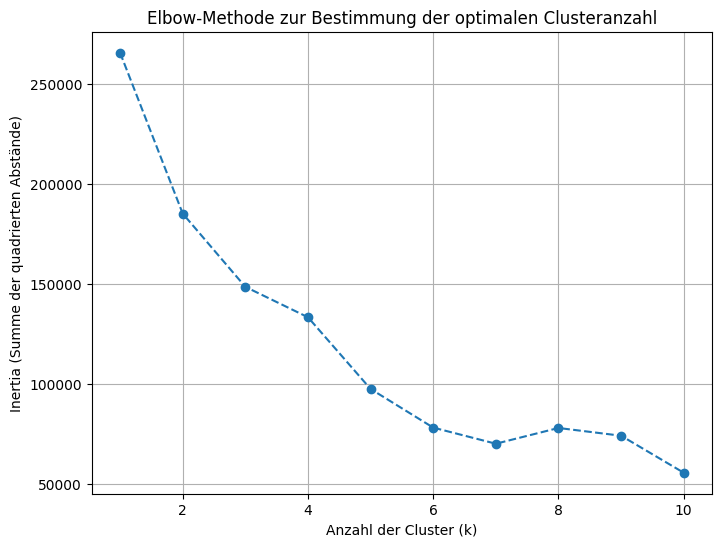

In [69]:
# 5. Elbow-Methode zur Bestimmung der optimalen Anzahl von Clustern
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusteranzahl")
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Summe der quadrierten Abstände)")
plt.grid(True)
plt.show()


Cluster-Zentren (5 Cluster):
Cluster 1:
  Gelieferte Energie = 12.40 kWh
  Ladezeit = 61.44 Stunden
  Stunde des Tages = 14.94
  Standort-ID = 1.90

Cluster 2:
  Gelieferte Energie = 10.29 kWh
  Ladezeit = 7.40 Stunden
  Stunde des Tages = 7.53
  Standort-ID = 1.00

Cluster 3:
  Gelieferte Energie = 35.55 kWh
  Ladezeit = 8.59 Stunden
  Stunde des Tages = 8.31
  Standort-ID = 1.18

Cluster 4:
  Gelieferte Energie = 7.98 kWh
  Ladezeit = 6.49 Stunden
  Stunde des Tages = 9.08
  Standort-ID = 2.00

Cluster 5:
  Gelieferte Energie = 8.02 kWh
  Ladezeit = 2.74 Stunden
  Stunde des Tages = 16.44
  Standort-ID = 1.65



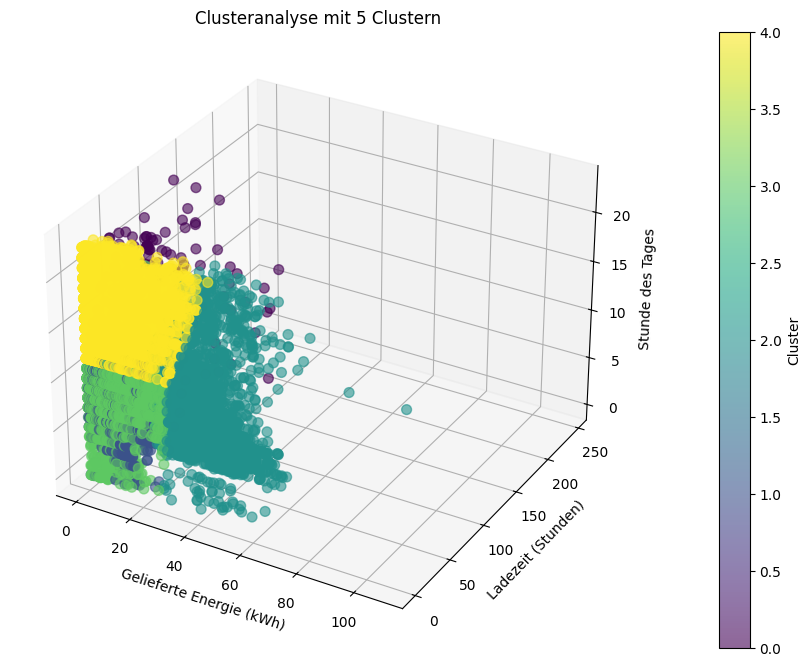

In [70]:
# 6. Clusteranalyse mit der optimalen Anzahl von Clustern
# Benutzer kann die optimale Anzahl der Cluster auswählen
optimal_k = int(input("Gib die optimale Anzahl der Cluster (k) ein: "))
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled_features)

# Cluster-Zentren zurückskalieren
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Cluster-Zentren ausgeben
print(f"\nCluster-Zentren ({optimal_k} Cluster):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i + 1}:")
    print(f"  Gelieferte Energie = {center[0]:.2f} kWh")
    print(f"  Ladezeit = {center[1]:.2f} Stunden")
    print(f"  Stunde des Tages = {center[2]:.2f}")
    print(f"  Standort-ID = {center[3]:.2f}")
    print()

# 7. Grafische Darstellung der Clusteranalyse
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    features['kWhDelivered'],
    features['duration'],
    features['hourOfDay'],
    c=features['cluster'], cmap='viridis', s=50, alpha=0.6
)

# Achsen beschriften
ax.set_xlabel("Gelieferte Energie (kWh)")
ax.set_ylabel("Ladezeit (Stunden)")
ax.set_zlabel("Stunde des Tages")
ax.set_title(f"Clusteranalyse mit {optimal_k} Clustern")

# Farbskala hinzufügen
cbar = plt.colorbar(scatter, pad=0.1, ax=ax)
cbar.set_label("Cluster")

plt.show()